# Initial Value Problems-for-ODE

## 09.01 Ordinary Differential Equations

Suppose that the state of a system is described by a vector-valued function $y : \mathbb{R} \rightarrow \mathbb{R}^n$ where the scalar domain of the function is typically something like time, $t$.

A **differential equation** describes the relationship between some function $y(t)$ and one or more of its derivatives with respect to $t$.
$$
y'(t) = \frac{dy}{dt}
$$

* The solution to a differential equation is the function $y(t)$ that satisfies the relationship.
* For an ordinary differential equation aka ODE all of the derivatives are with respect to a **single** independent variable.
* For a partial differential equation aka PDE the derivatives are with respect to **multiple** independent variables.
* The highest order derivative appearing in the ODE determines the **order**.

#### Example: Newton's Second Law of Motion
The differential equation $F = ma$ relates the position of an object in space to the second derivative.  

In one dimension where the position is described by $y(t)$ the second-order ODE is:
$$
F \left( t, y(t), \frac{dy}{dt} \right) = m \frac{d''y}{dt^2}
$$

The solution to this differential equation is:
$$
y(t) = - \frac{1}{2}gt^2 + c_1t + c_2
$$
where
* $c_1$ is a constant the describes the initial velocity
* $c_2$ is a constant the describes the initial position

#### Higher Order ODE
An ODE with higher order derivatives can be transformed into equivalent first-order system.

For kth order ODE:
$$
y^{(k)}(t) = f \left( t, y, y', \cdots, y^{(k-1)} \right)
$$

Define $k$ new unknown functions $u_k$:
$$
u_1(t) = y(t) \\
u_2(t) = y'(t) \\
\cdots \\
u_k(t) = y^{(k-1)}(t)
$$

Take the derivatives of the unknown functions to form the system of first-order equations:
$$
u'(t) =
\begin{bmatrix}
u_1'(t) \\
u_2'(t) \\
\vdots \\
u_k'(t)
\end{bmatrix} =
\begin{bmatrix}
u_2(t) \\
u_3(t) \\
\vdots \\
f(t, u_1, \cdots, u_k)
\end{bmatrix} =
g(t, u)
$$

#### Example: Newton's Second Law of Motion
The second-order ODE described previously can be rewritten as a system of first-order equations.

Define 2 new unknown functions $u_1$ and $u_2$:
$$
u_1(t) = y(t) \\
u_2(t) = y'(t)
$$

Take the derivatives of the unknown functions to form the system:
$$
\begin{bmatrix}
u_1' \\
u_2'
\end{bmatrix} =
\begin{bmatrix}
u_2 \\
F/m
\end{bmatrix}
$$
where
* $u_1$ is position
* $u_2$ is velocity which is first derivative of position
* $F/m$ is acceleration which is second derivative of position

#### Initial Value Problems
The ODE $y' = f(t, y)$ does not determine a unique solution.

The initial value $y(t_0) = y_0$ provided with the problem determines a unique solution to the ODE.
* If the $y_i$ are specified at different values of $t$, then we have a **boundary value problem**.

#### Example: Initial Value Problem
Notice that two conditions are specified at $t=0$.
$$
y'' = -y \\
y(t=0) = 1 \\
y'(t=0) = 0
$$

#### Example: Boundary Value Problem
Notice that two conditions are specified at $t=0$ and $t=\pi$.
$$
y'' = -y \\
y(t=0) = 1 \\
y(t=\pi) = 0
$$

Use scipy to solve the second order ODE given by the following problem.

A spacecraft is launched from an altitude h0 = 772km with initial speed v0 = 6700m/s.  The ODE describing the motion is:
$$
r'' = r (\theta')^2 - \frac{GM_e}{r^2} \\
\theta'' = - \frac{2 r' \theta'}{r}
$$
where
* $r$ and $\theta$ are the polar coordinates of the spacecraft

Integrate the ODE from time of launch until the spacecraft hits the Earth.  Determine the value of $\theta$ at the impact site.

In [1]:
import math
import numpy as np
import scipy.integrate as integrate

# Define some constants.
G = 6.672e-11
Me = 5.9742e24
Re = 6378.14e3  # Convert to m.

def fty(t, y):
    """
    Evaluate the n differential equations y^{(i)}(t) at t for i=1..n.
    
    y is an input vector with the following components
        y_0 = r
        y_1 = r'
        y_2 = \theta
        y_3 = \theta'

    Returns a vector of derivatives for each component of y.
        y_0' = r'
        y_1' = r''
        y_2' = \theta'
        y_3' = \theta''
    """
    ftyk = np.zeros(4)
    ftyk[0] = y[1]
    ftyk[1] = y[0]*y[3]*y[3] - (G*Me)/(y[0]*y[0])
    ftyk[2] = y[3]
    ftyk[3] = (-2.*y[1]*y[3])/y[0]
    return ftyk


# Setup the initial conditions.
h0, v0 = 772e3, 6700.
y0 = np.array([Re+h0, 0., 0., v0/(Re+h0)])
print("y0:", y0)

# Integrate from [0s, 20min] report y every 100s.
t0, tf, nsteps = 0., 1200., 1200./100.
t_eval = np.linspace(t0, tf, nsteps+1)
result = integrate.solve_ivp(fty, (t0, tf), y0, t_eval=t_eval, 
                             method='RK45')
np.testing.assert_equal(result.success, True)

# Print a table of time and altitude.
for t, r in zip(result.t, result.y[0,:]):
    msg = 'impact' if r < Re else ''
    print('t=%4.0f (s) r=%g (m) %s' % (t, r, msg))

# Find the index of the first time below Re.
inds = np.flatnonzero(result.y[0,:] <= Re)

# Compute time of impact by solving r + r'dt = Re for dt.
r, dr = result.y[0,inds[0]-1], result.y[1,inds[0]-1]
dt = (Re - r)/dr
t_impact = result.t[inds[0]-1] + dt
print("t_impact:     ", t_impact, " (s)")

# Compute theta at impact theta + theta'dt.
theta, dtheta = result.y[2,inds[0]-1], result.y[3,inds[0]-1]
theta_impact = theta + dtheta*dt
print("theta_impact: ", theta_impact, " (rad)")

y0: [7.15014000e+06 0.00000000e+00 0.00000000e+00 9.37044589e-04]
t=   0 (s) r=7.15014e+06 (m) 
t= 100 (s) r=7.14255e+06 (m) 
t= 200 (s) r=7.11981e+06 (m) 
t= 300 (s) r=7.08201e+06 (m) 
t= 400 (s) r=7.02935e+06 (m) 
t= 500 (s) r=6.96213e+06 (m) 
t= 600 (s) r=6.88072e+06 (m) 
t= 700 (s) r=6.78561e+06 (m) 
t= 800 (s) r=6.67737e+06 (m) 
t= 900 (s) r=6.55683e+06 (m) 
t=1000 (s) r=6.42499e+06 (m) 
t=1100 (s) r=6.28313e+06 (m) impact
t=1200 (s) r=6.13287e+06 (m) impact
t_impact:      1034.1772163714961  (s)
theta_impact:  1.047938964525584  (rad)


## 09.02 Stability of ODE Solutions

Stable
  * Solutions resulting from perturbations of initial value remain close to original solution.

Asymptotically stable
  * Solutions resulting from perturbations of initial value converge back to original solution.

Unstable
  * Solutions resulting from perturbations of initial value diverge away from original solution without bound.
  * Effects of the local error accumulate and as a result growth of global error is unbounded.

#### Example: Scalar ODE
Given ODE
$$
y' = \lambda y
$$

Initial conditions: $y(t=0) = y_0$

Solution
$$
y = y_0 e^{\lambda t}
$$

For real $\lambda$:
* $\lambda < 0$ asymptotically stable
* $\lambda > 0$ unstable

For complex $\lambda$:
* Same as above with real component $\text{Re}(\lambda)$
* $\text{Re}(\lambda) = 0$ stable, but not asymptotically stable

#### Example: Linear System ODE
Given ODE
$$
y' = Ay
$$
where
* $A$ is a $n \times n$ diagonalizable matrix (eg $n$ linearly independent eigenvectors $v$)

Initial conditions: $y(t=0) = y_0$ where $y_0 = \sum_{i=1}^n \alpha_i v_i$

Solution
$$
y(t) = \sum_{i=1}^n \alpha_i v_i e^{\lambda_i t}
$$
where
* $\alpha$ is taken from the linear combination of eigenvectors which forms $y_0$

Eigenvalues $\lambda$:
* $\lambda_i < 0$ asymptotically stable
* $\lambda_i > 0$ unstable
* $\lambda_i = 0$ oscillatory solution components

Plot a demonstration of a stable ODE, $y'(t) = 0.5$ and $y(t) = y_0 + 0.5t$.

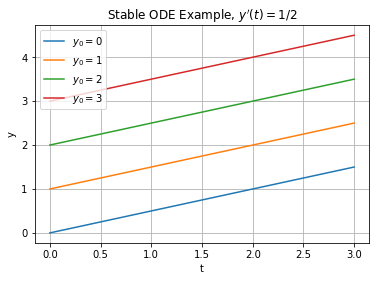

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

tmin, tmax, tnum = 0., 3., 100
t = np.linspace(tmin, tmax, tnum)

y0s = np.array([0., 1., 2., 3.])
labels = ['$y_0=0$', '$y_0=1$', '$y_0=2$', '$y_0=3$']

for y0, label in zip(y0s, labels):
    vft = np.vectorize(lambda t: 0.5*t + y0)
    plt.plot(t, vft(t), label=label)
plt.title('Stable ODE Example, $y\'(t) = 1/2$')
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

Plot a demonstration of a asymptotically stable ODE, $y'(t) = -y$ and $y(t) = y_0 e^{-t}$.

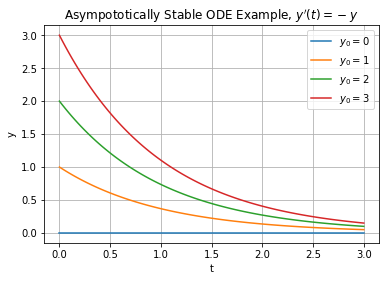

In [3]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

tmin, tmax, tnum = 0., 3., 100
t = np.linspace(tmin, tmax, tnum)

y0s = np.array([0., 1., 2., 3.])
labels = ['$y_0=0$', '$y_0=1$', '$y_0=2$', '$y_0=3$']

for y0, label in zip(y0s, labels):
    vft = np.vectorize(lambda t: y0*np.exp(-1.*t))
    plt.plot(t, vft(t), label=label)
plt.title('Asympototically Stable ODE Example, $y\'(t) = -y$')
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

Plot a demonstration of a unstable ODE, $y'(t) = y$ and $y(t) = y_0 e^t$.

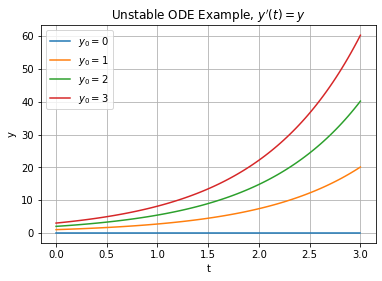

In [4]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

tmin, tmax, tnum = 0., 3., 100
t = np.linspace(tmin, tmax, tnum)

y0s = np.array([0., 1., 2., 3.])
labels = ['$y_0=0$', '$y_0=1$', '$y_0=2$', '$y_0=3$']

for y0, label in zip(y0s, labels):
    vft = np.vectorize(lambda t: y0*np.exp(t))
    plt.plot(t, vft(t), label=label)
plt.title('Unstable ODE Example, $y\'(t) = y$')
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

## 09.03 Euler's Method

#### Analytical vs. Numerical Solution
* Analytical solution of ODE is closed-form formula evaluated at any point $t$.
* Numerical solution of ODE is table of approximate values of solution at discrete set of points.

#### Euler's Method
Euler's method is a single-step method which advances solution by **extrapolating** along straight line of slope $f(t_k, y_k)$.
$$
y_{k+1} = y_k + h_k f(t_k, y_k)
$$

Given $t_0$ and $y_0$.
1. Set $k=0$.
2. Evaluate $f(t_k, y_k)$ to obtain the slope of trajectory.
3. Update the time-step as $t_{k+1} = t_k + h_k$.
4. Predict value at $y_{k+1}$ using $y_{k+1} = y_k + h_k f(t_k, y_k)$.
5. Set $k=k+1$ and repeat from step 2.

The step $y_k$ to $y_{k+1}$ adds some error to solution.
* As a result, the solution at $y_{k+1}$ is on a different trajectory than the previous solution at $y_k$.
* Stability of solutions determines whether the errors grow or diminish with increasing time step.

Euler's method is stable if:
* For scalar ODE, $h \leq 2/\lambda$.
* For linear system ODE, $h \leq 2/\lambda_{\text{max}}$ where $\lambda_{\text{max}}$ is the largest eigenvalue of the matrix of constant coefficients $A$.

#### Errors
Numerical methods for ODE incur 2 types of error:
1. *Rounding error* due to finite precision floating-point
2. *Truncation error* aka discretization error due to approximation method

**Truncation error** is dominant factor in determining accuracy and composed of:
1. *Global error* difference between computed solution and exact solution through initial point
$$
e_k = y_k - y(t_k)
$$
2. *Local error* difference between computed solution and solution passing through previous point
$$
l_k = y_k - u_{k-1}(t_k)
$$

If global error is **greater** than sum of local errors, then solution is **unstable**.

If global error is **less** than sum of local errors, then solution is **stable**.

Use Euler's method to solve the first order ODE $y' + 4y = t^2$ for the initial value $y(t=0) = 1$ for values of $t$ in the interval $[0, 2]$ using step-size $h=0.1$.

Compare the values at each step to the exact solution given by:
$$
y = \frac{31}{32}e^{-4t} + \frac{1}{4}t^2 - \frac{1}{8}t + \frac{1}{32}
$$

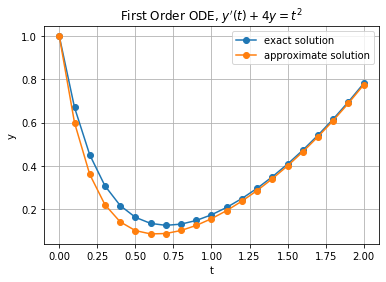

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def euler(fty, t0, y0, hk, nsteps):
    """
    Solve the ODE at y(t0) = y0 using Euler's method.
    
    fty is a function that evaluates y^{(i)}(t) at t for i=1..n.
    t0, y0 are the initial values.
    hk is the step-size.
    nsteps is the number of steps.
    
    Returns the approximate values of the solution at (t_i, y_i).
    """
    tk, yk = np.zeros(nsteps+1), np.zeros((nsteps+1, y0.size))
    tk[0], yk[0,:] = t0, y0
    for k in range(nsteps):
        ftyk = fty(tk[k], yk[k,:])
        tk[k+1] = tk[k] + hk
        yk[k+1] = yk[k] + hk*ftyk
    # NOTE(mmorais): Solution to n derivatives is first eqtn, y'(t) = y.
    return tk, yk[:,0]


def fty(t, y):
    """
    Evaluate the n differential equations y^{(i)}(t) at t for i=1..n.
    """
    return t*t - 4.*y[0]


# Initial values and number of steps.
t0, y0, hk, nsteps = 0., np.array([1.]), 0.1, 20
tk, yk = euler(fty, t0, y0, hk, nsteps)

# Compute the exact solution.
fy = lambda t: (31./32)*math.exp(-4.*t) + (1./4)*t*t - (1./8)*t + (1./32)
vfy = np.vectorize(fy)
yexact = vfy(tk)

# Plot approximate solution using Euler's method vs exact soltn.
plt.plot(tk, yexact, marker='o', label='exact solution')
plt.plot(tk, yk, marker='o', label='approximate solution')
plt.title('First Order ODE, $y\'(t) + 4y = t^2$')
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

Use Euler's method to solve the second order ODE $y'' = -0.1y' - t$ for the initial value $y(t=0) = 0$ and $y'(t=0) = 1$ for values of $t$ in the interval $[0, 2]$ using step-size $h=0.05$.

Compare the values at each step to the exact solution given by:
$$
y = 100t - 5t^2 + 990(e^{-0.1t} - 1)
$$

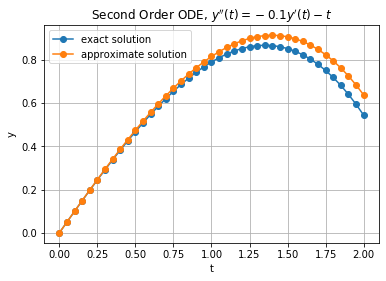

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def fty(t, y):
    """
    Evaluate the n differential equations y^{(i)}(t) at t for i=1..n.
    """
    ftyk = np.zeros(2)
    ftyk[0] = y[1]
    ftyk[1] = -0.1*y[1] - t
    return ftyk


# Initial values and number of steps.
t0, y0, hk, nsteps = 0., np.array([0., 1.]), 0.05, 40
tk, yk = euler(fty, t0, y0, hk, nsteps)

# Compute the exact solution.
fy = lambda t: 100.*t - 5.*t*t + 990.*(math.exp(-0.1*t) - 1.)
vfy = np.vectorize(fy)
yexact = vfy(tk)

# Plot approximate solution using Euler's method vs exact soltn.
plt.plot(tk, yexact, marker='o', label='exact solution')
plt.plot(tk, yk, marker='o', label='approximate solution')
plt.title("Second Order ODE, $y''(t) = -0.1y'(t) - t$")
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

## 09.04 Accuracy and Stability

Order of accuracy of numerical method is $p$ if local error $l_k = O(h_k^{p+1})$.

Global error is the local error per unit step or $e_k = l_k / h_k = O(h_k^p)$.

Stability has nothing to do with accuracy.
* An inaccurate method can be very stable.

Stability determined by the following factors:
* Differential equation being solved.
* Method of solution.
* Step size $h$.

## 09.05 Implicit Methods

An **explicit** method uses information at time $t_k$ to advance solution to time $t_{k+1}$.
* Example: Euler's method

An **implicit** method evalutes $f(t_{k+1}, y_{k+1})$ before we know the value of $y_{k+1}$.
* Use an iterative root-finding method to solve for $y_{k+1}$ using value of $y_k$ as initial guess.
* Example: Backward Euler method

#### Backward Euler method
Given $t_0$ and $y_0$.
1. Set $k=0$.
2. Update the time-step as $t_{k+1} = t_k + h_k$.
3. Determine the value of $y_{k+1}$ by solving $0 = y_k + h_k f(t_{k+1}, y_{k+1}) - y_{k+1}$ for $y_{k+1}$.
4. Set $k=k+1$ and repeat from step 2.

Backward Euler is unconditionally stable and first-order accurate.
* Stable for any positive step size.
* Only constraint on desired accuracy is the choice of step size.

#### Trapezoid Method
Higher accuracy can be obtained by averaging Euler and backward Euler methods.
$$
y_{k+1} = y_k + h_k \frac{f(t_k, y_k) + f(t_{k+1}, y_{k+1})}{2}
$$

Trapezoid method is unconditionally stable and second-order accurate.
* Better choice than Backward Euler.

Use backward Euler to solve the first order ODE $y' = -y^3$ for the initial value $y(t=0) = 1$ for values of t in the interval $[0, 2]$ using step-size $h = 0.5$.

Compare the values at each step to the exact solution given by:
$$
y = \frac{1}{\sqrt{2t + 1}}
$$

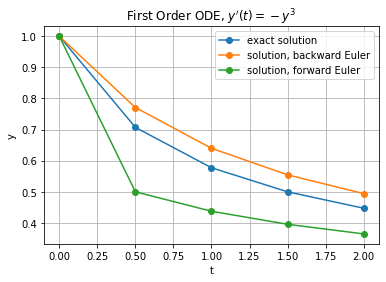

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

%matplotlib inline

def backward_euler(fty, t0, y0, hk, nsteps):
    """
    Solve the ODE at y(t0) = y0 using backward Euler method.
    
    fty is a function that evaluates y^{(i)}(t) at t for i=1..n.
    t0, y0 are the initial values.
    hk is the step-size.
    nsteps is the number of steps.
    
    Returns the approximate values of the solution at (t_i, y_i).
    """
    tk, yk = np.zeros(nsteps+1), np.zeros((nsteps+1, y0.size))
    tk[0], yk[0,:] = t0, y0
    for k in range(nsteps):
        tk[k+1] = tk[k] + hk
        # Solve 0 = yk + hk * f(tk1, yk1) - yk1 for yk1.
        f = lambda y: yk[k] + hk*fty(tk[k+1], y) - y
        ftyk = optimize.root(f, yk[k])
        # Solution yk1 becomes the next yk.
        yk[k+1] = ftyk.x
    # NOTE(mmorais): Solution to n derivatives is first eqtn, y'(t) = y.
    return tk, yk[:,0]


def fty(t, y):
    """
    Evaluate the n differential equations y^{(i)}(t) at t for i=1..n.
    """
    return -1.*math.pow(y[0], 3)


# Initial values and number of steps.
t0, y0, hk, nsteps = 0., np.array([1.]), 0.5, 4

# Compute the solution using backward Euler method.
tk, yk = backward_euler(fty, t0, y0, hk, nsteps)

# Compute the solution using forward Euler method.
tke, yke = euler(fty, t0, y0, hk, nsteps)

# Compute the exact solution.
fy = lambda t: 1./math.sqrt(2.*t + 1.)
vfy = np.vectorize(fy)
yexact = vfy(tk)

# Plot approximate solution using Euler's method vs exact soltn.
plt.plot(tk, yexact, marker='o', label='exact solution')
plt.plot(tk, yk, marker='o', label='solution, backward Euler')
plt.plot(tke, yke, marker='o', label='solution, forward Euler')
plt.title("First Order ODE, $y'(t) = -y^3$")
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

## 09.06 Stiffness

An initial value problem is **stiff** if some components in the solution vector $y(t)$ vary much more rapidly with $t$ than others.
* Stiffness results from a linear system ODE when there is a large disparity in the magnitudes of the positive eigenvalues.
* Physical interpretation: components of a system have different time scales.  For example, a chemical reaction with one or more periods of very rapid transitions in concentration of constituent components.

Stiffness is problem for numerical methods because the step size can be more severly restricted by stability than by accuracy.
* Euler method is extremely inefficient for stiff ODE.
* Backward Euler is suitable for stiff ODE because of unconditional stability.


## 09.07 Single-Step Methods

#### Runge-Kutta
Single-step method that replaces higher derivatives of the Taylor series with finite difference approximations based on values of $f$ at points between $t_k$ and $t_{k+1}$.

##### Second-Order
Heun's method, analogous to trapezoid method:
$$
y_{k+1} = y_k + \frac{h_k}{2}(k_1 + k_2)
$$
where
* $k_1 = f(t_k, y_k)$
* $k_2 = f(t_k + h_k, y_k + h_k k_1)$ (still explicit)

##### Fourth-Order
Analogous to Simpson's rule:
$$
y_{k+1} = y_k + \frac{h_k}{6}(k_1 + 2k_2 + 2k_3 + k_4)
$$
where
* $k_1 = f(t_k, y_k)$
* $k_2 = f(t_k + h_k/2, y_k + (h_k/2)k_1)$
* $k_3 = f(t_k + h_k/2, y_k + (h_k/2)k_2)$
* $k_4 = f(t_k + h_k, y_k + h_k k_3)$

#### Tradeoffs
Benefits of Runge-Kutta
* Self-starting eg no history of solution prior to time $t_k$ required to proceed to time $t_{k+1}$.
* Easy to change step size $h_k$ during integration.

Disadvantages of Runge-Kutta
* Provide no error estimate on which to base choice of step-size.
  * Embedded Runge-Kutta method proposed by Dormand and Prince use differences of pairs of method of different order to estimate error and adjust step-size. 
* Inefficient for stiff ODEs.

Use second-order Runge-Kutta to solve the first order ODE $y' = -2ty^2$ for the initial value $y(t=0) = 1$ for values of $t$ in the interval $[0, 2]$ using step-size $h = 0.25$.

Compare the values at each step to the exact solution given by:
$$
y = \frac{1}{t^2 + 1}
$$

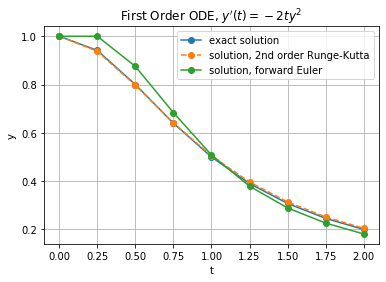

In [8]:
import math
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def rk2(fty, t0, y0, hk, nsteps):
    """
    Solve the ODE at y(t0) = y0 using second order Runge-Kutta.
    
    fty is a function that evaluates y^{(i)}(t) at t for i=1..n.
    t0, y0 are the initial values.
    hk is the step-size.
    nsteps is the number of steps.
    
    Returns the approximate values of the solution at (t_i, y_i).
    """
    tk, yk = np.zeros(nsteps+1), np.zeros((nsteps+1, y0.size))
    tk[0], yk[0,:] = t0, y0
    for k in range(nsteps):
        tk[k+1] = tk[k] + hk
        k1 = fty(tk[k], yk[k])
        k2 = fty(tk[k+1], yk[k] + hk*k1)
        yk[k+1] = yk[k] + (hk/2.)*(k1+k2)
    # NOTE(mmorais): Solution to n derivatives is first eqtn, y'(t) = y.
    return tk, yk[:,0]


def fty(t, y):
    """
    Evaluate the n differential equations y^{(i)}(t) at t for i=1..n.
    """
    return -2.*t*y*y


# Initial values and number of steps.
t0, y0, hk, nsteps = 0., np.array([1.]), 0.25, 8

# Compute the solution using second order Runge-Kutta.
tk, yk = rk2(fty, t0, y0, hk, nsteps)

# Compute the solution using forward Euler method.
tke, yke = euler(fty, t0, y0, hk, nsteps)

# Compute the exact solution.
fy = lambda t: 1./(t*t + 1.)
vfy = np.vectorize(fy)
yexact = vfy(tk)

# Plot approximate solution using Euler's method vs exact soltn.
plt.plot(tk, yexact, marker='o', label='exact solution')
plt.plot(tk, yk, marker='o', linestyle='--', 
         label='solution, 2nd order Runge-Kutta')
plt.plot(tke, yke, marker='o', label='solution, forward Euler')
plt.title("First Order ODE, $y'(t) = -2ty^2$")
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

Use fourth-order Runge-Kutta to solve the second order ODE $y'' = -0.1y' - t$ for the initial value $y(t=0) = 0$ and $y'(t=0) = 1$ for values of $t$ in the interval $[0, 2]$ using step-size $h = 0.2$.

Compare the values at each step to the exact solution given by:
$$
y = 100t - 5t^2 + 990(e^{-0.1t} - 1)
$$

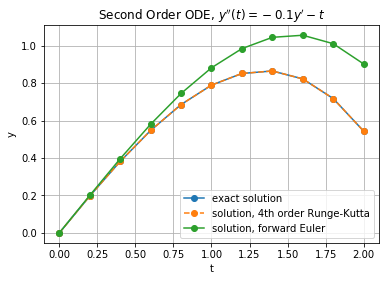

In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def rk4(fty, t0, y0, hk, nsteps):
    """
    Solve the ODE at y(t0) = y0 using fourth order Runge-Kutta.
    
    fty is a function that evaluates y^{(i)}(t) at t for i=1..n.
    t0, y0 are the initial values.
    hk is the step-size.
    nsteps is the number of steps.
    
    Returns the approximate values of the solution at (t_i, y_i).
    """
    tk, yk = np.zeros(nsteps+1), np.zeros((nsteps+1, y0.size))
    tk[0], yk[0,:] = t0, y0
    for k in range(nsteps):
        tk[k+1] = tk[k] + hk
        k1 = fty(tk[k], yk[k])
        k2 = fty(tk[k] + hk/2., yk[k] + (hk/2.)*k1)
        k3 = fty(tk[k] + hk/2., yk[k] + (hk/2.)*k2)
        k4 = fty(tk[k] + hk, yk[k] + hk*k3)
        yk[k+1] = yk[k] + (hk/6.)*(k1 + 2.*k2 + 2*k3 + k4)
    # NOTE(mmorais): Solution to n derivatives is first eqtn, y'(t) = y.
    return tk, yk[:,0]


def fty(t, y):
    """
    Evaluate the n differential equations y^{(i)}(t) at t for i=1..n.
    """
    ftyk = np.zeros(2)
    ftyk[0] = y[1]
    ftyk[1] = -0.1*y[1] - t
    return ftyk


# Initial values and number of steps.
t0, y0, hk, nsteps = 0., np.array([0., 1.]), 0.2, 10

# Compute the solution using fourth order Runge-Kutta.
tk, yk = rk4(fty, t0, y0, hk, nsteps)

# Compute the solution using forward Euler method.
tke, yke = euler(fty, t0, y0, hk, nsteps)

# Compute the exact solution.
fy = lambda t: 100.*t - 5.*t*t + 990.*(math.exp(-0.1*t) - 1.)
vfy = np.vectorize(fy)
yexact = vfy(tk)

# Plot approximate solution using Euler's method vs exact soltn.
plt.plot(tk, yexact, marker='o', label='exact solution')
plt.plot(tk, yk, marker='o', linestyle='--', 
         label='solution, 4th order Runge-Kutta')
plt.plot(tke, yke, marker='o', label='solution, forward Euler')
plt.title("Second Order ODE, $y''(t) = -0.1y' - t$")
plt.ylabel('y')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

## 09.08 Multistep Methods

Multistep methods based on polynomial interpolation use information at more than one previous point to estimate solution at next point.
$$
y_{k+1} = \sum_{i=1}^m \alpha_i y_{k+1-i} + h \sum_{i=0}^m \beta_i f(t_{k+1-1}, y_{k+1-i})
$$
where
* $\alpha_i$ and $\beta_i$ are determined by polynomial interpolation
* $h$ is the step-size and **must remain fixed** throughout the integration 

If $\beta_0 \neq 0$ then the method is implicit, else the method is explicit.

Possible strategies for handling points with insufficient prior history:
* Use single-step method until you reach sufficient number of points.
* Gradually increase the number of previous points.

#### Fourth-Order Accurate
Explicit Adams-Bashforth predictor
$$
y_{k+1} = y_k + \frac{h}{24} \left( 55y'_k - 59y'_{k-1} + 37y'_{k-2} - 9y'_{k-3} \right)
$$

Implicit Adams-Moulton corrector
$$
y_{k+1} = y_k + \frac{h}{24} \left( 9y'_{k+1} + 19y'_k - 5y'_{k-1} + y'_{k-2} \right)
$$

#### Tradeoffs
Benefits of multistep
* Good local error estimates obtained from difference between predictor and corrector.
* Implicit multistep can be effective for stiff ODE.

Disadvantages of multistep
* Not self-starting (unlike Runge-Kutta).
* Not easy to change step size (unlike Runge-Kutta) since formulas based on equally spaced intervals.

## 09.09 Multivalue Methods

Multivalue methods are like multistep methods in that they are based on polynomial interpolation, but differ in that the interpolating polynomial itself can be evaluated at any point, not just equally spaced intervals.

#### Tradeoffs
Benefits of multivalue
* Easy to change step size.
* Easy to change order of method by changing components of $r$.

#### Variable Order and Step Size ODE Solvers
Multivalue methods are the basis for sophisticated solvers.
* Step size and order is varied to meet user-supplied error tolerance (like adaptive quadrature).
* Detect stiffness automatically and take appropriate measures (such as transition to implicit methods).

## Summary: Initial Value Problems for ODE

* Numerical solution of ODE is table of approximate values of solution at discrete set of points.
* Truncation error is the dominant factor in determining accuracy of a solution and consists of *local error* and *global error*.
  * In an unstable solution, the effects of local error accumulate and the growth in global error is unbounded.
* Euler's method is an explicit single-step method with first-order accuracy. 
  * Extrapolates a solution along a line whose slope is given by the right hand side of ODE.
  * Stability depends upon stability of ODE aka $\lambda$ and step-size $h$.
* Implicit methods improve stability.
  * First-order accuracy: Backward Euler
  * Second-order accuracy: Trapezoid method
  * Unconditionally stable.
  * Only constraint on accuracy is choice of step size.
  * Good for stiff ODE.
* Higher order Runge-Kutta methods improve accuracy.
* Multivalue methods are the basis for sophisticated solvers that vary step size and order to meet user supplied error tolerance.